<a href="https://colab.research.google.com/github/dbtjr1103/Dacon_practice/blob/main/Kaggle_2_5D_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
# !git clone https://github.com/huggingface/pytorch-image-models.git

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 13030, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 13030 (delta 90), reused 127 (delta 79), pack-reused 12882
Receiving objects: 100% (13030/13030), 23.40 MiB | 9.89 MiB/s, done.
Resolving deltas: 100% (9361/9361), done.
Updating files: 100% (516/516), done.


In [4]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.3 MB/s eta 0:00:00


In [37]:
import os
import sys
sys.path.append('/content/drive/MyDrive/kaggle/pytorch-image-models')
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

In [38]:
# 모델을 바꿀때 하이퍼파라미터 값들도 적절히 변경해주어야 함.
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 100, 
    'valid_bs': 64,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 2
}

In [39]:
# 랜덤 시드값을 고정, 변경할 사항 없음
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 해시 함수가 동일한 출력을 생성하도록 파이썬 해시 시드 값을 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # 연산에 대한 랜덤 시드값을 고정
    torch.cuda.manual_seed(seed) # 연산에 대한 랜덤 시드값을 고정
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns. contact_id 컬럼을 4개로 나눔
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

labels = expand_contact_id(pd.read_csv("/content/drive/MyDrive/kaggle/nfl-player-contact-detection/sample_submission.csv"))

test_tracking = pd.read_csv("/content/drive/MyDrive/kaggle/nfl-player-contact-detection/test_player_tracking.csv")

test_helmets = pd.read_csv("/content/drive/MyDrive/kaggle/nfl-player-contact-detection/test_baseline_helmets.csv")

test_video_metadata = pd.read_csv("/content/drive/MyDrive/kaggle/nfl-player-contact-detection/test_video_metadata.csv")

In [41]:
labels

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2
0,58168_003392_0_38590_43854,0,58168_003392,0,38590,43854
1,58168_003392_0_38590_41257,0,58168_003392,0,38590,41257
2,58168_003392_0_38590_41944,0,58168_003392,0,38590,41944
3,58168_003392_0_38590_42386,0,58168_003392,0,38590,42386
4,58168_003392_0_38590_47944,0,58168_003392,0,38590,47944
...,...,...,...,...,...,...
49583,58172_003247_125_40656_G,0,58172_003247,125,40656,G
49584,58172_003247_125_52521_G,0,58172_003247,125,52521,G
49585,58172_003247_125_52939_G,0,58172_003247,125,52939,G
49586,58172_003247_125_39008_G,0,58172_003247,125,39008,G


In [42]:
test_tracking

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58172_003247,58172,3247,41937,2020-09-13T19:30:20.200Z,-272,home,MLB,57,64.28,11.29,4.82,0.46,20.74,12.43,3.13,3.00
1,58172_003247,58172,3247,45345,2020-09-13T19:30:20.200Z,-272,away,ILB,50,76.03,36.74,3.15,0.32,179.52,184.91,1.87,-1.81
2,58172_003247,58172,3247,46205,2020-09-13T19:30:20.200Z,-272,home,DE,98,65.64,15.74,1.80,0.20,6.73,339.85,0.69,-0.68
3,58172_003247,58172,3247,43406,2020-09-13T19:30:20.200Z,-272,home,WR,14,36.35,14.94,1.81,0.18,330.50,344.03,0.62,0.39
4,58172_003247,58172,3247,48233,2020-09-13T19:30:20.200Z,-272,away,RB,45,76.10,32.15,3.36,0.34,166.59,180.56,0.88,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14867,58168_003392,58168,3392,43395,2020-09-11T03:01:57.300Z,92,away,FS,23,51.03,13.63,1.70,0.17,21.01,18.32,0.35,-0.20
14868,58168_003392,58168,3392,39947,2020-09-11T03:01:57.300Z,92,home,T,72,42.73,18.52,1.19,0.13,331.22,332.97,0.58,-0.56
14869,58168_003392,58168,3392,44822,2020-09-11T03:01:57.300Z,92,home,QB,15,35.01,18.68,1.48,0.15,165.22,162.66,0.38,-0.07
14870,58168_003392,58168,3392,38590,2020-09-11T03:01:57.300Z,92,home,G,70,43.72,18.24,1.54,0.16,341.08,336.00,0.41,-0.41


In [43]:
test_helmets

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33
...,...,...,...,...,...,...,...,...,...,...,...,...
47325,58172_003247,58172,3247,Sideline,58172_003247_Sideline.mp4,1082,52852,H38,460,40,315,45
47326,58172_003247,58172,3247,Sideline,58172_003247_Sideline.mp4,1082,41937,H57,729,43,473,45
47327,58172_003247,58172,3247,Sideline,58172_003247_Sideline.mp4,1082,48233,V45,126,33,504,35
47328,58172_003247,58172,3247,Sideline,58172_003247_Sideline.mp4,1082,48241,V22,446,38,511,45


In [44]:
test_video_metadata

,game_play,game_key,play_id,view,start_time,end_time,snap_time
0,58168_003392,58168,3392,Endzone,2020-09-11T03:01:43.134Z,2020-09-11T03:01:54.971Z,2020-09-11T03:01:48.134Z
1,58168_003392,58168,3392,Sideline,2020-09-11T03:01:43.134Z,2020-09-11T03:01:54.971Z,2020-09-11T03:01:48.134Z
2,58172_003247,58172,3247,Endzone,2020-09-13T19:30:42.414Z,2020-09-13T19:31:00.524Z,2020-09-13T19:30:47.414Z
3,58172_003247,58172,3247,Sideline,2020-09-13T19:30:42.414Z,2020-09-13T19:31:00.524Z,2020-09-13T19:30:47.414Z


In [ ]:
'''
ffmpeg 라이브러리를 사용하여 주어진 경로에 있는 동영상 파일을 읽고, 프레임을 추출하여 이미지 파일로 저장 
코드 실행 시, test_helmets 데이터 프레임에서 고유한 비디오 파일의 리스트를 추출하고, 
해당 리스트에서 "Endzone2"라는 문자열이 포함되어 있지 않은 동영상 파일에 대해 프레임 추출 작업을 수행

추출된 프레임은 /work/frames 폴더에 비디오 파일명과 일련번호를 사용하여 jpg 형식으로 저장

추출된 프레임의 화질을 나타내는 -q:v 2 옵션을 사용

오류 및 진행상황 메시지를 숨기기 위해 -hide_banner 및 -loglevel error 옵션을 사용
'''
# !mkdir -p ../work/frames

# for video in tqdm(test_helmets.video.unique()):
#     if 'Endzone2' not in video:
#         !ffmpeg -i /content/drive/MyDrive/kaggle/nfl-player-contact-detection/test/{video} -q:v 2 -f image2 /content/drive/MyDrive/kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error

100%|██████████| 4/4 [01:00<00:00, 15.16s/it]


In [14]:
import os
tmp = os.listdir('/content/drive/MyDrive/kaggle/work/frames')

In [15]:
len(tmp)

3590

In [45]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

test, feature_cols = create_features(labels, test_tracking, use_cols=use_cols)
test

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58168_003392_0_37084_37211,0,58168_003392,0,37084,37211,41.90,20.08,0.54,0.06,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,0,58168_003392,0,37084,38556,41.90,20.08,0.54,0.06,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,0,58168_003392,0,37084,38590,41.90,20.08,0.54,0.06,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,0,58168_003392,0,37084,39947,41.90,20.08,0.54,0.06,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49583,58172_003247_125_52521_52939,0,58172_003247,125,52521,52939,23.44,4.04,1.41,0.15,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,14.629204,False
49584,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
49585,58172_003247_125_52852_52939,0,58172_003247,125,52852,52939,32.67,2.18,2.34,0.24,...,37.94,2.10,2.29,0.24,211.73,215.11,2.43,-2.43,5.270607,False
49586,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [46]:
feature_cols

['x_position_1',
 'y_position_1',
 'speed_1',
 'distance_1',
 'direction_1',
 'orientation_1',
 'acceleration_1',
 'sa_1',
 'x_position_2',
 'y_position_2',
 'speed_2',
 'distance_2',
 'direction_2',
 'orientation_2',
 'acceleration_2',
 'sa_2',
 'distance',
 'G_flug']

In [47]:
test_filtered = test.query('not distance>2').reset_index(drop=True)
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1
test_filtered

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame
0,58168_003392_0_37084_38567,0,58168_003392,0,37084,38567,41.90,20.08,0.54,0.06,...,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False,300
1,58168_003392_0_37084_G,0,58168_003392,0,37084,G,41.90,20.08,0.54,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
2,58168_003392_0_37211_46445,0,58168_003392,0,37211,46445,39.59,17.07,0.53,0.05,...,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False,300
3,58168_003392_0_37211_G,0,58168_003392,0,37211,G,39.59,17.07,0.53,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
4,58168_003392_0_38556_G,0,58168_003392,0,38556,G,41.93,30.61,0.67,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6626,58172_003247_125_48241_G,0,58172_003247,125,48241,G,33.86,-1.28,0.79,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6627,58172_003247_125_48335_G,0,58172_003247,125,48335,G,44.74,3.16,4.72,0.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6628,58172_003247_125_52521_G,0,58172_003247,125,52521,G,23.44,4.04,1.41,0.15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049
6629,58172_003247_125_52852_G,0,58172_003247,125,52852,G,32.67,2.18,2.34,0.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1049


In [65]:
filtered_test_contact = test_filtered[test_filtered['contact'] == 1]

In [66]:
filtered_test_contact

,contact_id,contact,game_play,step,nfl_player_id_1,nfl_player_id_2,x_position_1,y_position_1,speed_1,distance_1,...,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug,frame


In [48]:
del test, labels, test_tracking
gc.collect()

19

In [49]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [50]:
video2helmets = {}
test_helmets_new = test_helmets.set_index('video')
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop=True)
    
del test_helmets, test_helmets_new
gc.collect()

100%|██████████| 4/4 [00:00<00:00, 146.67it/s]


0

In [51]:
video2helmets

{'58168_003392_Endzone.mp4':          game_play  game_key  play_id     view  frame  nfl_player_id  \
 0     58168_003392     58168     3392  Endzone    290          39947   
 1     58168_003392     58168     3392  Endzone    290          37211   
 2     58168_003392     58168     3392  Endzone    290          38590   
 3     58168_003392     58168     3392  Endzone    290          44822   
 4     58168_003392     58168     3392  Endzone    290          41944   
 ...            ...       ...      ...      ...    ...            ...   
 7069  58168_003392     58168     3392  Endzone    709          41257   
 7070  58168_003392     58168     3392  Endzone    709          43395   
 7071  58168_003392     58168     3392  Endzone    709          37211   
 7072  58168_003392     58168     3392  Endzone    709          46445   
 7073  58168_003392     58168     3392  Endzone    709          42386   
 
      player_label  left  width  top  height  
 0             H72   946     25  293      34  


In [52]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'/content/drive/MyDrive/kaggle/work/frames/{video}*'))))

100%|██████████| 2/2 [00:00<00:00, 13.97it/s]


In [53]:
# 딕셔너리를 데이터프레임으로 변환
video2frames

{'58168_003392_Endzone.mp4': 711,
 '58168_003392_Sideline.mp4': 711,
 '58172_003247_Endzone.mp4': 1084,
 '58172_003247_Sideline.mp4': 1084}

In [57]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
#             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    img = cv2.imread(f'/content/drive/MyDrive/kaggle/work/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label

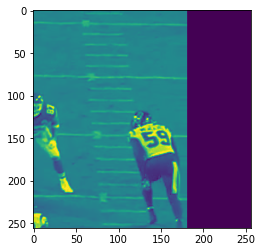

(torch.Size([26, 256, 256]),
 array([ 4.193e+01,  3.061e+01,  6.700e-01,  5.000e-02,  2.325e+02,
         2.270e+02,  1.820e+00,  1.610e+00, -1.000e+00, -1.000e+00,
        -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,
        -1.000e+00, -1.000e+00,  1.000e+00], dtype=float32),
 0.0)

In [72]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[4]
plt.imshow(img.permute(1,2,0)[:,:,7])
plt.show()
img.shape, feature, label

In [71]:
label

0.0

In [59]:
tmp

['58172_003247_Sideline.mp4_0861.jpg',
 '58172_003247_Sideline.mp4_0862.jpg',
 '58172_003247_Sideline.mp4_0863.jpg',
 '58172_003247_Sideline.mp4_0864.jpg',
 '58172_003247_Sideline.mp4_0865.jpg',
 '58172_003247_Sideline.mp4_0866.jpg',
 '58172_003247_Sideline.mp4_0867.jpg',
 '58172_003247_Sideline.mp4_0868.jpg',
 '58172_003247_Sideline.mp4_0869.jpg',
 '58172_003247_Sideline.mp4_0870.jpg',
 '58172_003247_Sideline.mp4_0871.jpg',
 '58172_003247_Sideline.mp4_0872.jpg',
 '58172_003247_Sideline.mp4_0873.jpg',
 '58172_003247_Sideline.mp4_0874.jpg',
 '58172_003247_Sideline.mp4_0875.jpg',
 '58172_003247_Sideline.mp4_0876.jpg',
 '58172_003247_Sideline.mp4_0877.jpg',
 '58172_003247_Sideline.mp4_0878.jpg',
 '58172_003247_Sideline.mp4_0879.jpg',
 '58172_003247_Sideline.mp4_0880.jpg',
 '58172_003247_Sideline.mp4_0881.jpg',
 '58172_003247_Sideline.mp4_0882.jpg',
 '58172_003247_Sideline.mp4_0883.jpg',
 '58172_003247_Sideline.mp4_0884.jpg',
 '58172_003247_Sideline.mp4_0885.jpg',
 '58172_003247_Sideline.m

In [74]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=False, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [76]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=CFG['num_workers'], pin_memory=True)

model = Model().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/kaggle/resnet50_fold0.pt'))

model.eval()

Model(
  (backbone): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [77]:
y_pred = []
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        if(step % 4 != 3):
            img, feature, label = [x.to(device) for x in batch]
            output1 = model(img, feature).squeeze(-1)
            output2 = model(img.flip(-1), feature).squeeze(-1)
            
            y_pred.extend(0.2*(output1.sigmoid().cpu().numpy()) + 0.8*(output2.sigmoid().cpu().numpy()))
        else:
            img, feature, label = [x.to(device) for x in batch]
            output = model(img.flip(-1), feature).squeeze(-1)
            y_pred.extend(output.sigmoid().cpu().numpy())    

y_pred = np.array(y_pred)

100%|██████████| 104/104 [25:12<00:00, 14.55s/it]


In [78]:
y_pred

array([0.0041154 , 0.00973676, 0.00100008, ..., 0.01578115, 0.0192989 ,
       0.01299736], dtype=float32)

In [80]:
th = 0.29

test_filtered['contact'] = (y_pred >= th).astype('int')

sub = pd.read_csv('/content/drive/MyDrive/kaggle/nfl-player-contact-detection/sample_submission.csv')

sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0


In [83]:
sub[sub['contact']==1]

,contact_id,contact
556,58168_003392_2_41944_42565,1
809,58168_003392_3_41944_42565,1
1036,58168_003392_4_43854_46445,1
1062,58168_003392_4_41944_42565,1
1289,58168_003392_5_43854_46445,1
...,...,...
48575,58172_003247_121_47912_G,1
48810,58172_003247_122_43406_G,1
49063,58172_003247_123_43406_G,1
49316,58172_003247_124_43406_G,1
